In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
#from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt

## 1. 데이터 불러오기

### Boston Housing Dataset

- 보스턴 주택 가격 데이터
- 1978년에 발표된 데이터로 미국 보스턴 지역의 주택 가격에 영향을 미치는 요소들을 정리
- 총 13가지의 요소들과 주택 가격으로 이루어져 있음.

### 데이터 호출

In [2]:
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None)
X_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_boston = raw_df.values[1::2, 2]
column_names = ['CRM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\njh45\AppData\Local\Temp\ipykernel_15040\1469471495.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None)


### 데이터 분할
- Training set 70%, Test set 30% 무작위 추출을 이용하여 나누기


In [3]:
X_train, X_test, y_train, y_test = \
train_test_split(X_boston, y_boston,
                 test_size = 0.3, random_state=123)

## 2. 앙상블

### 2.0 Decision Tree

In [4]:
tree = DecisionTreeRegressor(max_depth = 5,    #아래 그림이 나오게 빈칸에 의사결정나무 함수 작성
                             random_state = 0)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

### 예측

In [5]:
tree_pred = tree.predict(X_test)
print(np.power(y_test-tree_pred,2).mean())

17.602204873990754


### 2.1 Bagging

### 모형적합

In [6]:
tree = DecisionTreeRegressor()
bag_model = BaggingRegressor(tree, n_estimators=1000,
                             max_samples=0.8, random_state=1)
bag_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_samples=0.8,
                 n_estimators=1000, random_state=1)

### 예측

In [10]:
bag_pred = bag_model.predict(X_test)

#MAE 계산식 작성 (모르겠으면 위에꺼 참고)
print(np.abs(y_test-bag_pred).mean())

2.3376190789473736


### 2.2 Random Forest

### 모형적합

In [11]:
rf_model = RandomForestRegressor(n_estimators=1000,  #아래 그림처럼 나오게 하이퍼파라미터 작성
                                 max_features=3,
                                 min_samples_leaf=3)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features=3, min_samples_leaf=3, n_estimators=1000)

### 예측

In [12]:
rf_pred = rf_model.predict(X_test)

#MSE계산식 작성
print(np.power(y_test-rf_pred,2).mean())

16.493938309368847


### 2.3 Boosting

### 모형적합

In [13]:
gbm_model = GradientBoostingRegressor(n_estimators=1000,  #그래디언트부스팅함수 작성
                                      max_depth=3)
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000)

### 예측

In [14]:
gbm_pred = gbm_model.predict(X_test)
print(np.power(y_test-gbm_pred,2).mean())

13.285733626742209


### Partial Dependence Plot

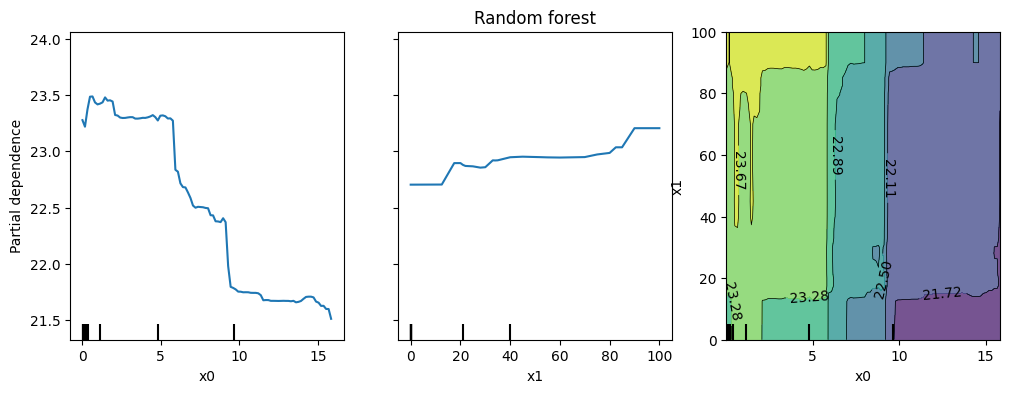

In [ ]:
# R.F 모델의 부분 의존도 PDP 그래프
# 해당 피처가 모델의 예측에 기여하는 정도를 정량적으로 평가한 것으로
# 특정 변수값이 변할 때 예측값의 증/감을 확인함
# 다른 피처들은 전부 고정하고 진행

#from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title('Random forest', fontsize=12)
tree_disp = PartialDependenceDisplay.from_estimator(rf_model, X_train, [0,1,[0,1]], ax=ax)

### 각 그래프를 해석하시오
1. x0 값이 증가할수록 예측값이 점진적으로 감소하는 경향이 존재함. x0=5 부근에서 모델이 영향을 많이 받음

2. x1 값이 증가할수록 예측값이 점진적으로 증가하는 경향이 존재함. x1=90 부근에서 모델이 영향을 많이 받음

3. x0, x1의 조합에 따른 예측값의 변화를 색상으로 표현한 것으로 그래프에 나타난 Label을 같이 살펴봐야 해석이 쉽다. 23.67이라는 높은 예측값을 살펴보면 x0가 작고, x1이 클 때이다.

= 해당 그래프는 특정 변수가 빠질 때 예측값의 증/감을 살펴볼 수 있는 것이다. 이 예측값이 '좋은값'인지 판단하기 위해선 task 이해가 필수겠군

### Variable Importance Plot

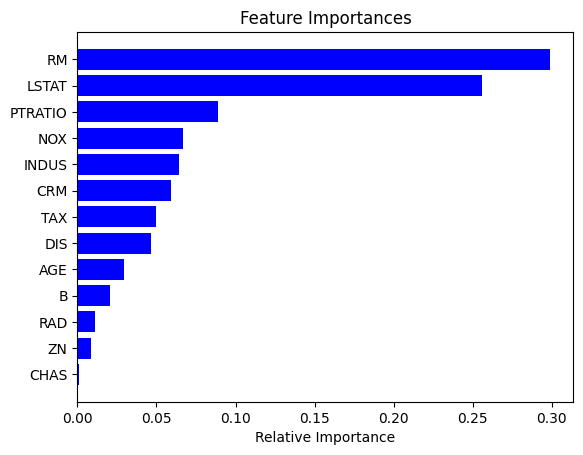

In [ ]:
# 피처 중요도
# 모델이 특정 피처를 얼마나 중요하게 사용했는지를 정량적으로 평가
# 피처를 제거했을 때 모델의 성능 변화 등을 기반으로 계산

importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [column_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()